# Capstone Project: Classifying clinically actionable genetic mutations

***

## Notebook 1: Data Cleaning and Exploratory Data Analysis (EDA)

This notebook contains the Problem Statement and code for data cleaning and EDA.

### Contents

- [Problem Statement](#Problem-Statement)
- Executive Summary
- [Importing of Libraries](#Importing-of-Libraries)

## Problem Statement

To build and train a classifier to propose the correct classification of genetic variations based on an expert-annotated knowledge base of cancer mutation annotations and related biomedical terms, so that clinical pathologists can spend less effort manually reviewing medical literature to make the classification (refer to the "Data Interpretation" step in the workflow diagram below). The model performance will be guided by the best accuracy and AUC scores, and the model should improve upon the baseline by at least 10% - the baseline being defined as the proportion of the majority variant class in the given training set.

<img src="../assets/workflow.jpg" height="500" width="500"/>

Source: Kumar-Sinha, C., Chinnaiyan, A. Precision oncology in the age of integrative genomics. Nat Biotechnol 36, 46–60 (2018). https://doi.org/10.1038/nbt.4017

## Importing of Libraries

In [10]:
# pip install imblearn

In [2]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.utils import resample

from imblearn.over_sampling import SMOTE

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import nltk
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from collections import Counter
from wordcloud import WordCloud

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


## Data Collection

### Import Training Datasets

In [11]:
train_text = pd.read_csv("../assets/training_text.txt", sep="\|\|", engine='python')
train_variants = pd.read_csv("../assets/training_variants.txt")

In [12]:
train_text.shape, train_variants.shape

((3321, 1), (3321, 4))

In [13]:
train_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID,Text  3316 non-null   object
dtypes: object(1)
memory usage: 51.9+ KB


We notice that there are missing values for 'text' that we need to clean up.

In [14]:
train_text.head()

,"ID,Text"
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,Abstract Background Non-small cell lung canc...
2,Abstract Background Non-small cell lung canc...
3,Recent evidence has demonstrated that acquired...
4,Oncogenic mutations in the monomeric Casitas B...


In [15]:
train_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


We note that there are no missing data in the train_variants data.

In [16]:
train_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


### Import Testing Datasets

In [17]:
test_text = pd.read_csv("../assets/test_text.csv", sep="\|\|", engine='python')
test_variants = pd.read_csv("../assets/test_variants.csv")

In [18]:
test_text.shape, test_variants.shape

((986, 1), (986, 3))

In [19]:
test_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 1 to 986
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID,Text  986 non-null    object
dtypes: object(1)
memory usage: 15.4+ KB


We note that there are no missing data in the test_text dataset.

In [20]:
test_text.head()

,"ID,Text"
1,The incidence of breast cancer is increasing i...
2,An unselected series of 310 colorectal carcino...
3,Mycosis fungoides and SÃ©zary syndrome are pri...
4,Regulated progression through the cell cycle ...
5,Pilocytic astrocytoma (PA) is emerging as a tu...


In [21]:
test_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         986 non-null    int64 
 1   Gene       986 non-null    object
 2   Variation  986 non-null    object
dtypes: int64(1), object(2)
memory usage: 23.2+ KB


We note that there are no missing data in the test_variants data.

In [22]:
test_variants.head()

,ID,Gene,Variation
0,1,CHEK2,H371Y
1,2,AXIN2,Truncating Mutations
2,3,WNT4,E216G
3,4,SUCLA2,G118R
4,5,BRAF,T599insTT


## Data Cleaning & Munging

In [23]:
# Create 'id' columns
train_text['id'] = train_text.index
test_text['id'] = test_text.index

In [24]:
# Rename the columns
train_text.rename(columns = {'ID,Text':'text'}, inplace = True)
test_text.rename(columns = {'ID,Text':'text'}, inplace = True)

In [25]:
train_text = train_text[['id','text']]
test_text = test_text[['id','text']]

In [26]:
train_variants.columns = [x.lower() for x in train_variants.columns]
test_variants.columns = [x.lower() for x in test_variants.columns]

In [27]:
# merge the "_text" and "_variant" files for both training and test
train = train_text.merge(train_variants)
test = test_text.merge(test_variants)

In [28]:
train.shape, test.shape

((3321, 5), (986, 4))

### Cleaning the training dataset

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3321 non-null   int64 
 1   text       3316 non-null   object
 2   gene       3321 non-null   object
 3   variation  3321 non-null   object
 4   class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [30]:
train[train['text'].isnull()]

,id,text,gene,variation,class
1109,1109,NaN,FANCA,S1088F,1
1277,1277,NaN,ARID5B,Truncating Mutations,1
1407,1407,NaN,FGFR3,K508M,6
1639,1639,NaN,FLT1,Amplification,6
2755,2755,NaN,BRAF,G596C,7


Given that the classifications of gene and variant to the target feature ('class') are important, we do not remove the missing rows. Instead, we replace the missing values with an empty string.

In [31]:
train['text'] = train['text'].fillna("")

In [32]:
# We verify that there are no more missing data in the 'text' column
train[train['text'].isnull()]

,id,text,gene,variation,class


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3321 non-null   int64 
 1   text       3321 non-null   object
 2   gene       3321 non-null   object
 3   variation  3321 non-null   object
 4   class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


## Exploratory Data Analysis (EDA)

In [38]:
train.describe(include='all')

,id,text,gene,variation,class
count,3321.000000,3321,3321,3321,3321.000000
unique,NaN,1921,264,2996,NaN
top,NaN,The PTEN (phosphatase and tensin homolog) phos...,BRCA1,Truncating Mutations,NaN
freq,NaN,53,264,93,NaN
mean,1660.000000,NaN,NaN,NaN,4.365854
std,958.834449,NaN,NaN,NaN,2.309781
min,0.000000,NaN,NaN,NaN,1.000000
25%,830.000000,NaN,NaN,NaN,2.000000
50%,1660.000000,NaN,NaN,NaN,4.000000
75%,2490.000000,NaN,NaN,NaN,7.000000


We note that there are actually duplicate 'text' values given that we have only 1,921 unique entries of 'text' out of the total of 3,321 rows.

We now take a closer look at some statistics for the 'text' length.

In [39]:
train['text'].str.len().describe()

count      3321.000000
mean      63865.602830
std       52373.225851
min           0.000000
25%       31450.000000
50%       46292.000000
75%       80347.000000
max      525740.000000
Name: text, dtype: float64

In [40]:
print ("Skew: {}".format(train['text'].str.len().skew()))
print ("Kurtosis: {}".format(train['text'].str.len().kurtosis()))

Skew: 2.6501447822500057
Kurtosis: 10.972881565762028


The skewness is positive (2.65) which represents a right skewed distribution. The high kurtosis (>3) means that there are more outliers than the normal distribution.

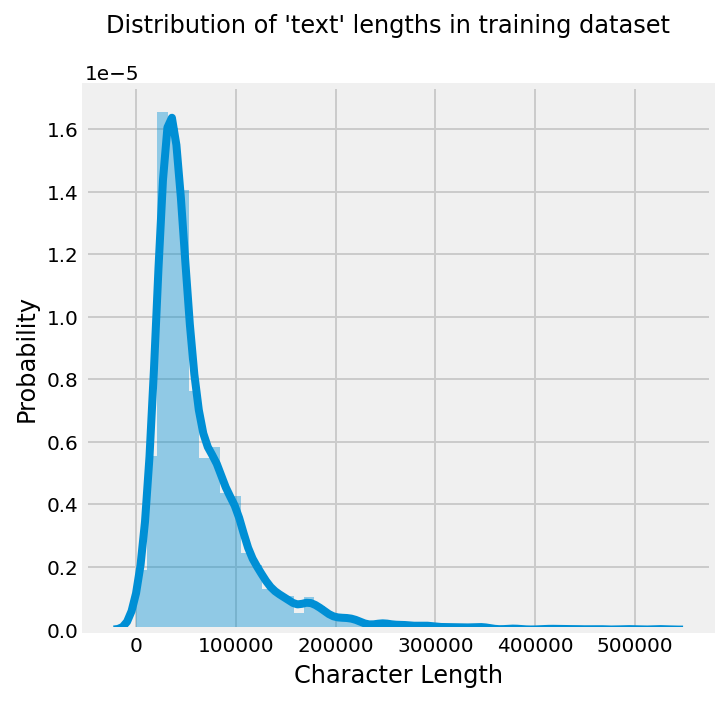

In [41]:
fig = plt.figure(figsize=(5,5))
sns.distplot(train['text'].str.len());
plt.suptitle("Distribution of 'text' lengths in training dataset")
plt.xlabel("Character Length")
plt.ylabel("Probability")
plt.show(fig)

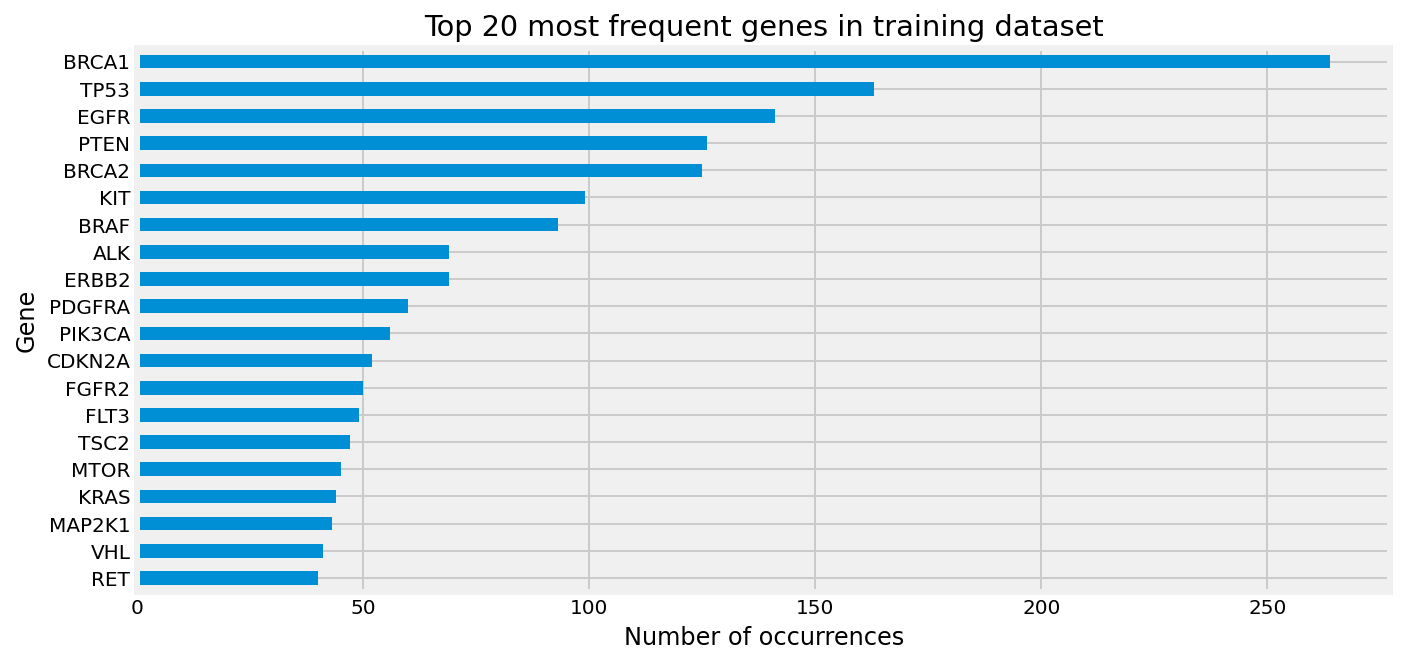

In [42]:
fig = plt.figure(figsize=(10,5))
plt.title('Top 20 most frequent genes in training dataset');
plt.xlabel("Number of occurrences")
plt.ylabel("Gene")
train['gene'].value_counts()[:20].sort_values(ascending=True).plot(kind='barh');
plt.show(fig)

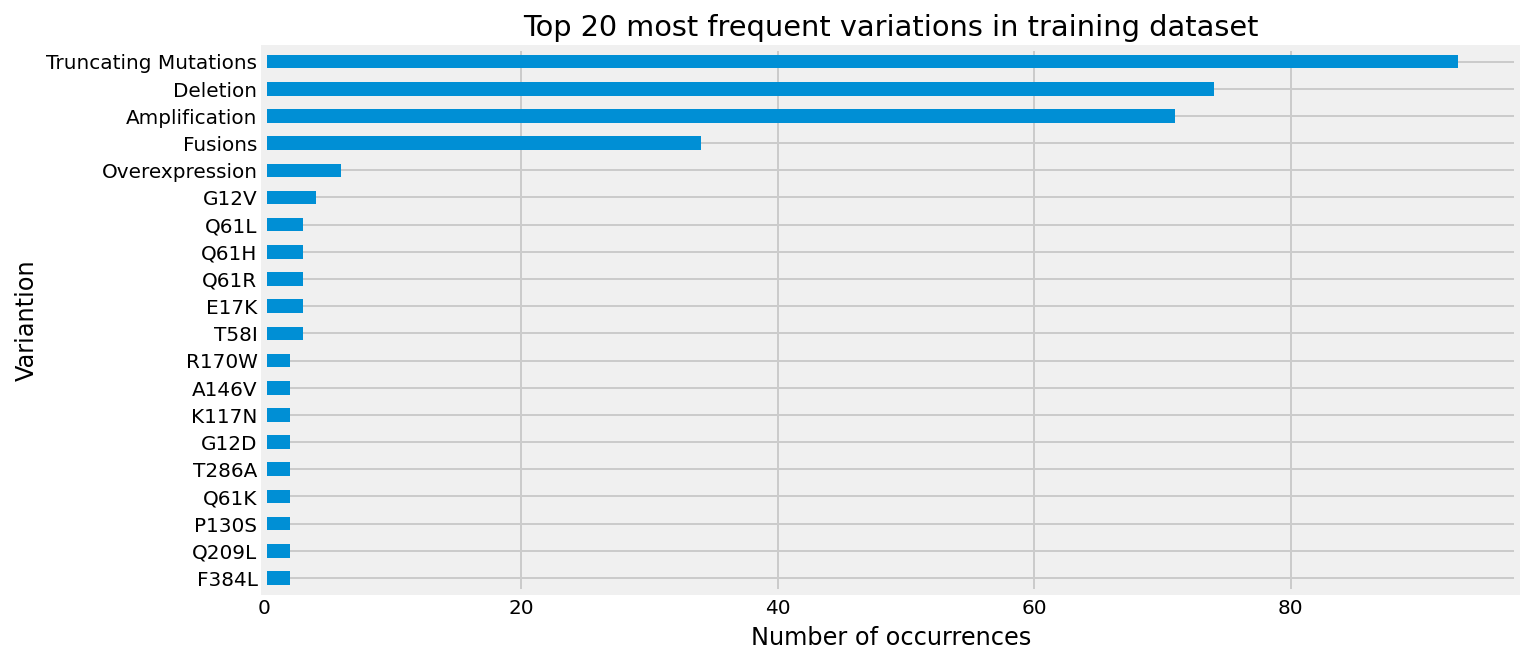

In [43]:
fig = plt.figure(figsize=(10,5))
plt.title('Top 20 most frequent variations in training dataset');
plt.xlabel("Number of occurrences")
plt.ylabel("Variantion")
train['variation'].value_counts()[:20].sort_values(ascending=True).plot(kind='barh');
plt.show(fig)

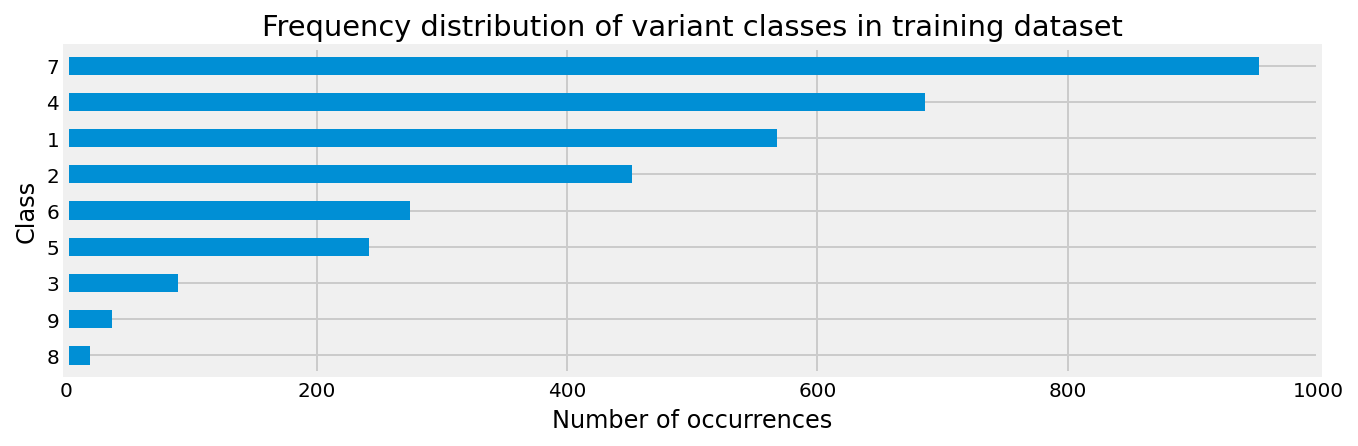

In [44]:
fig = plt.figure(figsize=(10,3))
plt.title('Frequency distribution of variant classes in training dataset');
plt.xlabel("Number of occurrences")
plt.ylabel("Class")
train['class'].value_counts().sort_values(ascending=True).plot(kind='barh');
plt.show(fig)

We note above that the **training set is highly imbalanced** -- i.e. classes 4 and 7 alone take up almost 50% of all classes found in the training set. We will need to deal with this when we fit the various candidate classifiers.

## Baseline Accuracy

We need to calculate baseline accuracy in order to tell if our model is outperforming the null model (predicting the majority class).

In [45]:
train['class'].value_counts(normalize=True)

7    0.286962
4    0.206564
1    0.171033
2    0.136104
6    0.082806
5    0.072870
3    0.026799
9    0.011141
8    0.005721
Name: class, dtype: float64

The proportion of the data points having the 'class' of 7 (i.e. **0.286962**) serves as our baseline (y-mean) statistic. Any model we create should not perform worse than this statistic.

## Data Export

We now export the cleaned training and testing datasets.

In [46]:
train.shape, test.shape

((3321, 5), (986, 4))

In [47]:
# write out the csv files for subsequent pre-processing
train.to_csv("../assets/train_clean.csv", index=False)
test.to_csv("../assets/test_clean.csv", index=False)